In [270]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

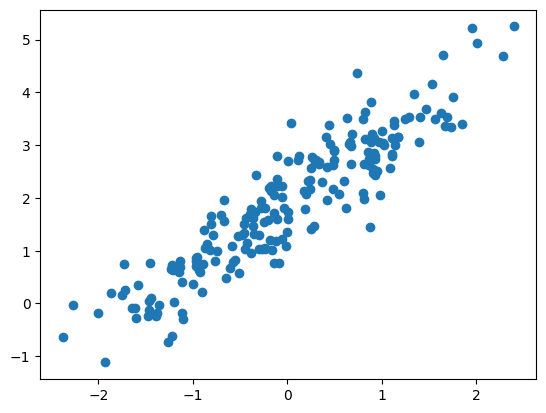

In [271]:
# simulate true model and observed data
N_observations = 200

slope = 1.2
intercept = 1.9
noise_eps = 0.5
x = np.random.normal(0,1, N_observations)#.sample(N_observations)
noise = np.random.normal(0,noise_eps, N_observations)

y = slope*x + intercept + noise

# Convert x and y to TensorFlow tensors
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

plt.scatter(x,y)

In [272]:
# Target model
model = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc=1., scale=1., name='m'),   # m
    tfd.Normal(loc=1., scale=1., name='b'),   # b
    tfd.HalfNormal(scale=.7, name='eps'),        # eps
    lambda eps, b, m: tfd.Normal(loc=b*x + m, scale=eps, name='y') # Y
])

# Define target_log_prob_fn like this to remove y from the input
target_log_prob_fn = lambda m, b, eps: model.log_prob([m, b, eps, y])


# surrogate
def get_surrogate():

    return tfd.JointDistributionSequentialAutoBatched([   
     # m 
    tfd.Normal(
            loc=tf.Variable(1., name='q_m_loc'),
            scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_m_scale'), name='q_m'),
    # b
    tfd.Normal(
            loc=tf.Variable(1., name='q_b_loc'),
            scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_b_scale'), name='q_b'),
    #tfd.HalfNormal(
    #        scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_b_scale'), name='q_b'),
    # eps
    tfd.LogNormal(
            loc=tf.Variable(0.1, name='q_eps_loc'),
            scale=tfp.util.TransformedVariable(.5, bijector=tfb.Softplus(), name='q_eps_scale'), name='q_eps'),
    #tfd.HalfNormal(
    #        scale=tfp.util.TransformedVariable(0.3, bijector=tfb.Softplus(), name='q_eps_scale'), name='q_eps')
])

surrogate = get_surrogate()

print('Trainable variables. Surrogate')
for i, v in enumerate(surrogate.trainable_variables):
    print(i, ':', v)


print('\nmodel graph')
print(model.resolve_graph())

print('\nsurrogate graph')
print(surrogate.resolve_graph())

print('Examples log probs (sample)')
sample = surrogate.sample(5)
for i in sample:
    print(i)
#print(target_log_prob_fn(*sample[::-1]).numpy())
print(target_log_prob_fn(*sample).numpy())
print(surrogate.log_prob(*sample).numpy())

Trainable variables. Surrogate
0 : <tf.Variable 'q_m_loc:0' shape=() dtype=float32, numpy=1.0>
1 : <tf.Variable 'q_m_scale:0' shape=() dtype=float32, numpy=0.54132485>
2 : <tf.Variable 'q_b_loc:0' shape=() dtype=float32, numpy=1.0>
3 : <tf.Variable 'q_b_scale:0' shape=() dtype=float32, numpy=0.54132485>
4 : <tf.Variable 'q_eps_loc:0' shape=() dtype=float32, numpy=0.1>
5 : <tf.Variable 'q_eps_scale:0' shape=() dtype=float32, numpy=-0.43275213>

model graph
(('m', ()), ('b', ()), ('eps', ()), ('y', ('eps', 'b', 'm')))

surrogate graph
(('q_m', ()), ('q_b', ()), ('q_eps', ()))
Examples log probs (sample)
tf.Tensor([ 1.0272796  -0.20466661  1.4045122   0.5859616   0.84648144], shape=(5,), dtype=float32)
tf.Tensor([1.7647759  0.10584009 0.6515994  2.0716252  1.0852556 ], shape=(5,), dtype=float32)
tf.Tensor([0.45533156 1.8897275  0.49997345 1.4886976  0.5329784 ], shape=(5,), dtype=float32)
[-667.46277 -480.94424 -357.15884 -390.16675 -542.80945]
[-3.1423302 -4.4009924 -2.771308  -3.298965 

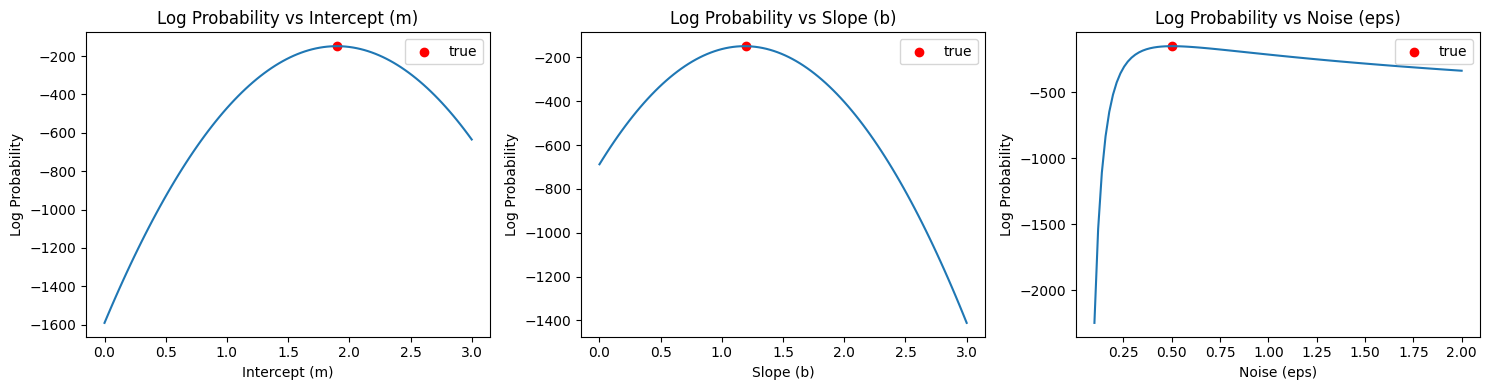

In [273]:
# Test to verify the logprob. create a marginal plot over each parameters logprob given the other params have the true value.
if True:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Intercept (m) plot
    m_linspace = np.linspace(0, 3, 100)
    logprobs_m = [target_log_prob_fn(m_i, slope, noise_eps) for m_i in m_linspace]

    axs[0].plot(m_linspace, logprobs_m)
    axs[0].scatter(intercept, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[0].set_xlabel("Intercept (m)")
    axs[0].set_ylabel("Log Probability")
    axs[0].legend()
    axs[0].set_title("Log Probability vs Intercept (m)")

    # Slope (b) plot
    b_linspace = np.linspace(0, 3, 100)
    logprobs_b = [target_log_prob_fn(intercept, b_i, noise_eps) for b_i in b_linspace]

    axs[1].plot(b_linspace, logprobs_b)
    axs[1].scatter(slope, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[1].set_xlabel("Slope (b)")
    axs[1].set_ylabel("Log Probability")
    axs[1].legend()
    axs[1].set_title("Log Probability vs Slope (b)")

    # Noise (eps) plot
    eps_linspace = np.linspace(0.1, 2, 100)
    logprobs_eps = [target_log_prob_fn(intercept, slope, eps_i) for eps_i in eps_linspace]

    axs[2].plot(eps_linspace, logprobs_eps)
    axs[2].scatter(noise_eps, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[2].set_xlabel("Noise (eps)")
    axs[2].set_ylabel("Log Probability")
    axs[2].legend()
    axs[2].set_title("Log Probability vs Noise (eps)")

    plt.tight_layout()
    plt.show()

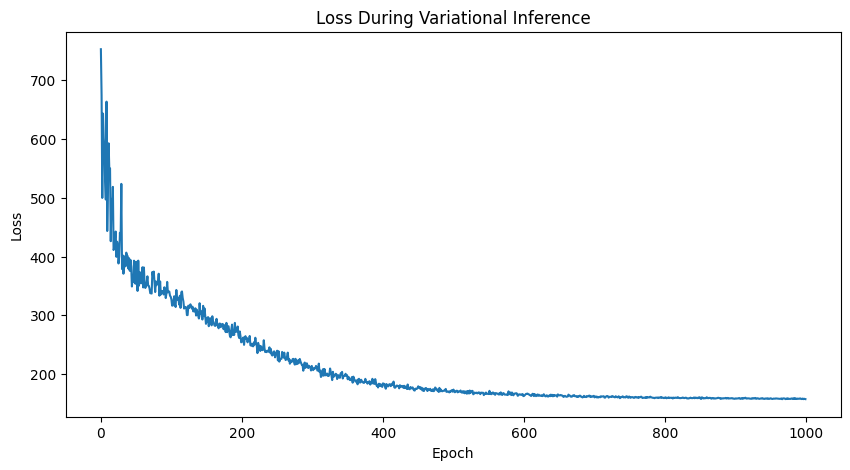

In [274]:
num_steps = 1000
sample_size = 64
learning_rate = 0.01

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_log_prob_fn,
    surrogate_posterior=surrogate,
    optimizer=optimizer,
    num_steps=num_steps,
    sample_size=sample_size
)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss During Variational Inference")
plt.show()

In [275]:
[m, b, eps] = np.mean(surrogate.sample(1000), axis=1)
print(m, b , eps)

1.8938655 1.1825205 0.52000195


In [276]:
print('True params')
print('intercept', intercept)
print('slope', slope)
print('noise_eps', noise_eps)

True params
intercept 1.9
slope 1.2
noise_eps 0.5


# Predictions

In [277]:
x_test = np.random.normal(0,1, 5)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [278]:
# Alternative 1 : means of the surrogate posterior distributions to make predictions is a form of point estimation
[m, b, eps] = np.mean(surrogate.sample(1000), axis=1)

prediction_model = tfd.Normal(loc=b*x_test + m, scale=eps)

point_preds = prediction_model.sample()
print(point_preds)


tf.Tensor(
[ 0.76009053 -0.4762345   2.0855463   1.5157108   3.3805802   2.9800537
  0.89662206  3.0394607  -1.6973062   3.8527827   0.8224641   1.2171382
  0.3945931   1.6985149   4.469907    1.3509259   0.99533474  3.8892233
  1.6071473   2.1849537   0.5031005   2.2181349   2.3759012   2.1834316
  3.6705668   2.5191183   2.069233    1.371429    2.6200826   2.997407
 -0.05029157  2.8618577   1.8051099   2.5741606   0.25160682  2.97773
  3.7693815  -0.36532724 -0.7556773   1.2540286   1.6603189   1.1251957
  1.8294508   1.8460556   3.7200117   1.4735055   2.4401746  -0.25014615
  1.6878217   3.189733  ], shape=(50,), dtype=float32)


In [279]:
# Alt 1.b

pe_preds_deterministic = b*x_test + m
noise = tf.random.normal(shape=x_test.shape, mean=0., stddev=eps)
pe_preds_w_noise = pe_preds_deterministic + noise

print(pe_preds_deterministic)
print(pe_preds_w_noise)

tf.Tensor(
[ 0.9732459  -0.24696577  1.8157581   0.98428595  2.326087    1.8098478
  0.6872293   3.08078    -1.096414    3.886616    1.2839906   1.4340115
  0.8741286   2.1287045   3.46037     0.9382388   1.2063992   3.9890428
  1.7152513   1.5614334   0.54364157  1.1492796   2.4440713   2.4799635
  3.487504    1.5559968   1.4814728   1.5311435   2.7440364   2.8144836
 -0.01948643  2.440582    1.9760777   1.6122631   1.0224603   2.2779064
  2.9456503   0.885625   -0.2852453   1.7098019   1.9377565   1.9686904
  1.5370586   2.0088294   3.3983924   1.7373024   1.8783137  -0.22088134
  1.6791826   2.0518365 ], shape=(50,), dtype=float32)
tf.Tensor(
[ 1.4786608   1.1899955   1.4285544   1.328775    2.3724115   1.5872691
  0.14608741  2.7963963  -1.2146683   4.400554    2.222814    1.2676151
  1.0928373   1.2759743   3.873155    0.9803046   1.6941077   4.4352484
  1.0458546   1.7977072   0.68496937  1.7940044   3.52703     3.3621538
  2.4558382   1.6277663   2.1679559   1.5345542   1.879474

In [282]:
# Alt 2.
n_samples = 1000
samples = surrogate.sample(n_samples)

m_samples = tf.reshape(samples[0], [n_samples, 1])
b_samples = tf.reshape(samples[1], [n_samples, 1])
eps_samples = tf.reshape(samples[2], [n_samples, 1])


prediction_model = tfd.Normal(loc=b_samples*x_test + m_samples, scale=eps_samples)

preds = prediction_model.sample()

mean_preds = tf.reduce_mean(preds, axis=0)
stddev_prediction = tf.math.reduce_std(preds, axis=0)

In [283]:
mean_preds

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.9946881 , -0.2502254 ,  1.8049043 ,  0.97901964,  2.340376  ,
        1.7852793 ,  0.7130901 ,  3.090771  , -1.0957204 ,  3.8583355 ,
        1.2561904 ,  1.4488145 ,  0.91046894,  2.1191034 ,  3.4834614 ,
        0.9191624 ,  1.198945  ,  3.9912958 ,  1.7094358 ,  1.5404621 ,
        0.5324635 ,  1.1440762 ,  2.4498093 ,  2.4647088 ,  3.5145135 ,
        1.5365461 ,  1.4554332 ,  1.5308082 ,  2.747916  ,  2.824266  ,
       -0.01430609,  2.438585  ,  1.9572778 ,  1.6239794 ,  1.011383  ,
        2.2959483 ,  2.9419508 ,  0.89495033, -0.28987643,  1.7295951 ,
        1.9564893 ,  1.9825231 ,  1.5470523 ,  1.999434  ,  3.3980556 ,
        1.7431674 ,  1.8847898 , -0.21518424,  1.6701767 ,  2.0624304 ],
      dtype=float32)>

In [284]:
stddev_prediction

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([0.5196919 , 0.5372582 , 0.51084626, 0.52429724, 0.5116761 ,
       0.5127543 , 0.50702566, 0.534991  , 0.5592753 , 0.54871905,
       0.5219734 , 0.5571861 , 0.54229724, 0.52886784, 0.52921754,
       0.5262176 , 0.52100605, 0.53170323, 0.52705306, 0.52800703,
       0.5378402 , 0.52375096, 0.50730896, 0.5310403 , 0.5381869 ,
       0.533738  , 0.5326166 , 0.52084184, 0.5197429 , 0.52158296,
       0.5296889 , 0.5290136 , 0.5284658 , 0.5262549 , 0.52286   ,
       0.5229305 , 0.5391101 , 0.5406476 , 0.531844  , 0.54203737,
       0.5321493 , 0.52696496, 0.5178909 , 0.5261407 , 0.5340848 ,
       0.5253013 , 0.52941865, 0.53754497, 0.52410334, 0.5029856 ],
      dtype=float32)>